In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import pickle as _pkl
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

In [4]:
PARS = _pnd.read_table('data/pars.txt', sep=',')
GENO = _nmp.loadtxt('data/1000G_chr7_100K_200K_005pc_5pc.txt', dtype='int')
MAF = GENO.sum(0) / (2 * GENO.shape[0])

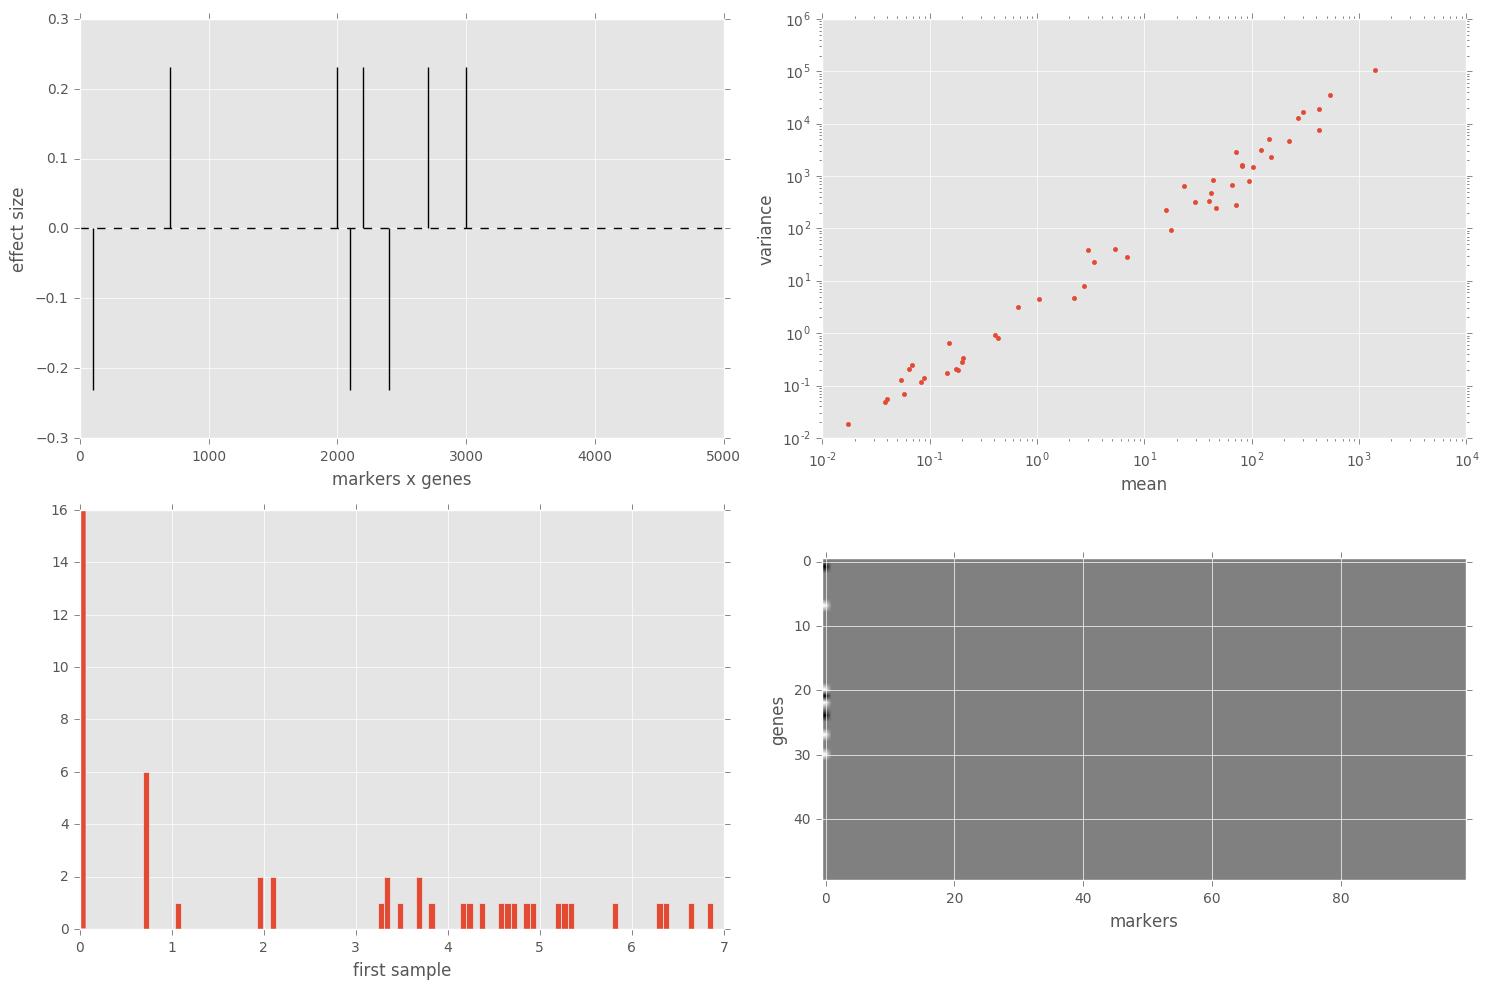

In [134]:
def fcn(n_samples=1000, n_markers=100, n_genes=50, pattern=(1, 8, 0, 0), size=4, pois=0., out=('S',0.1,5,10)):
    n_samples_max, n_markers_max = GENO.shape
    n_genes_max, _ = PARS.shape

    assert n_samples <= n_samples_max
    assert n_genes <= n_genes_max
    assert n_markers <= n_markers_max
    
#     G = GENO[:n_samples,:n_markers]
    G = _assoc.simulate_genotypes(MAF, n_samples, n_markers)['G']
    
    idxs = _rnd.choice(n_genes_max, n_genes, replace=False)
    mu = PARS['mu'].values[idxs]
    phi = PARS['phi'].values[idxs]
    
    pheno = _assoc.simulate_eQTLs(G, mu, phi, pattern=pattern, size=size, pois=pois, out=out)

    _plt.figure(figsize = (15,10));
    _plt.subplot(2,2,1); _plt.vlines(range(n_markers * n_genes), 0, pheno['beta'].ravel()); 
    _plt.axhline(linestyle='--', color='k'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
    _plt.subplot(2,2,2); _plt.loglog(pheno['mu'], pheno['mu'] + pheno['mu']**2 * pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(2,2,3); _plt.hist(_nmp.log(pheno['Z'][:,0]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(2,2,4); _plt.imshow(pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')

    _plt.tight_layout()
    
    return {'G': G, **pheno}

##
data = fcn()

In [154]:
_rnd.seed(0)
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
Z = _assoc.transform_data(Z, kind='blom')
res = _assoc.run(Z, data['G'], n_iters = 2000, model='Normal', scale=True, n_threads=1)

100%|██████████| 2000/2000 [00:04<00:00, 401.01it/s]


([0.23246783457669234, 0.625, 0.375, 5, 3, 4989, 3], 0.50662501766303436)

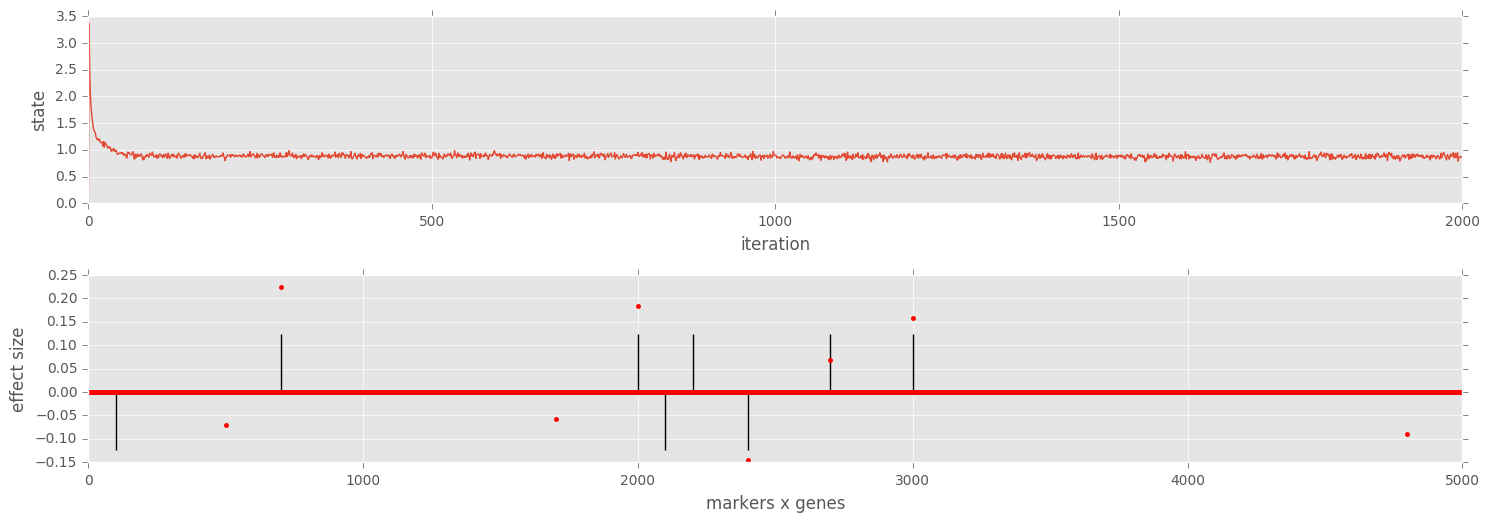

In [155]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

    beta_estim = res['beta'] / _nmp.abs(res['beta']).sum()
    beta_true = data['beta'] / _nmp.abs(data['beta']).sum()
    n_genes, n_markers = beta_true.shape

    _plt.subplot(4,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    if 'mu' in res:
        G = data['G']
    #     G = (G - _nmp.mean(G, 0)) / _nmp.std(G, 0)
        folds_true = _nmp.mean(G.dot(beta_true.T), 0) * data['mu']
        folds_estim = _nmp.mean(G.dot(beta_estim.T), 0) * res['mu']
        n_samples, _ = G.shape
        _plt.subplot(4,1,3); 
        _plt.vlines(range(n_genes), 0, folds_true.ravel()); 
        _plt.axhline(linestyle='--', color='k');
        _plt.plot(folds_estim.ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
    
    if 'Y' in res:
        _plt.subplot(4,1,4); 
        _plt.plot(res['Y'].ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
        _plt.axhline(linestyle='--', color='k');

    _plt.tight_layout()
        
    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            var_tru = data['mu'] + data['phi'] * data['mu']**2
            var_est = res['mu'] + res['phi'] * res['mu']**2
            
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(var_tru), _nmp.log(var_est), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

            _plt.subplot(2,2,3)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')
                        
    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
[metrics[_] for _ in ['RSS', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']], metrics['MCC']/(metrics['RSS'] + 1)

(0.25623450276623566, 1.3862943611198908)

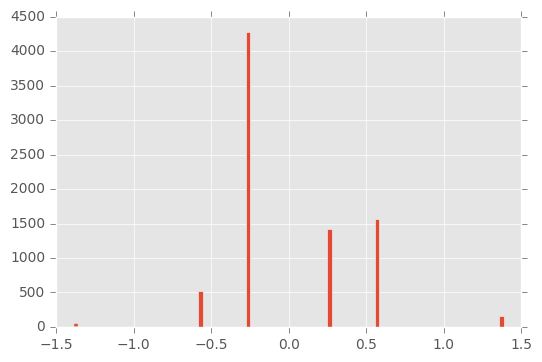

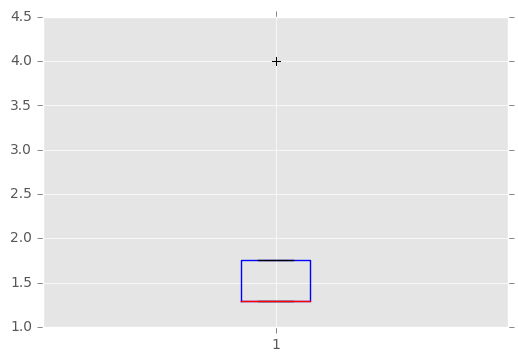

In [12]:
G = (data['G'] - _nmp.mean(data['G'], 0)) / _nmp.std(data['G'], 0)
folds = G.dot(data['beta'].T)
_plt.figure(); _plt.hist(folds[folds!=0], 100)
_plt.figure(); _plt.boxplot(_nmp.exp(_nmp.abs(folds))[folds!=0])
_nmp.min(_nmp.abs(folds[folds!=0])), _nmp.max(_nmp.abs(folds[folds!=0]))

In [ ]:
G = _nmp.loadtxt('data/1000G_chr7_100K_200K_005pc_5pc.txt', dtype='int')
maf = G.sum(0) / (2 * G.shape[0])
_plt.hist(maf, 100);

In [163]:
_nmp.exp((2.5, 1.3862943611198908))

array([ 12.18249396,   4.        ])

In [244]:
data['outliers'][0].size

500

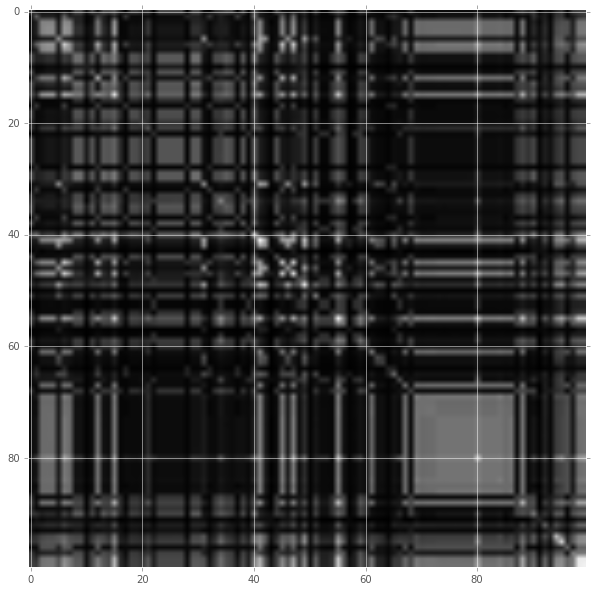

In [331]:
M = GENO[:,:100].T.dot(GENO[:,:100])
_plt.figure(figsize=(10,10));
_plt.imshow(M, cmap=_plt.cm.Greys_r);

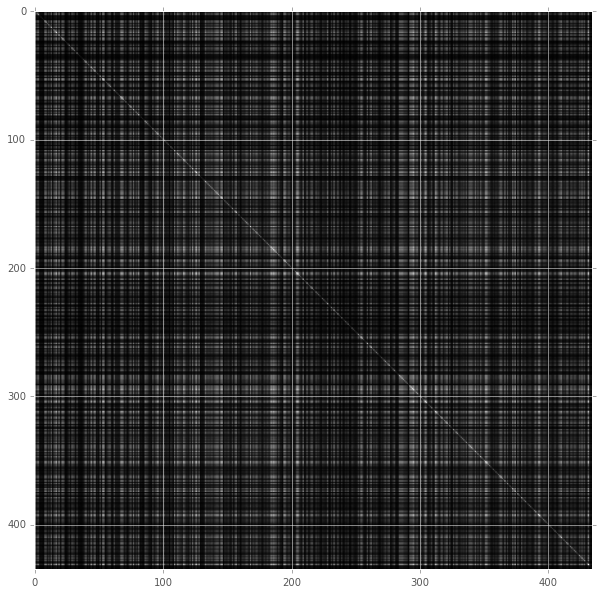

In [319]:
G = _assoc.simulate_genotypes(MAF, *GENO.shape)['G']
_plt.figure(figsize=(10,10));
_plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);

In [347]:
import scipy.signal as _sgn

In [352]:
_nmp.correlate([0,0,0,0,1,0,0,0,0],[0,0,0,0,1,,0,0,0])

array([1])

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

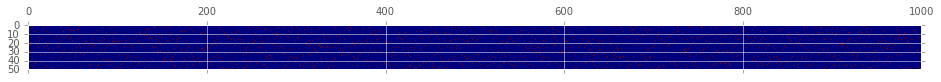

In [159]:
_plt.matshow(data['outliers'])
_nmp.sum(data['outliers'], 0)

In [151]:
0.05 * 50

2.5

In [8]:
tmp = _rnd.choice([True, False], size = (100, 50), p = [0.05, 1 - 0.05])

In [9]:
tmp.sum()

276

In [10]:
276/5000

0.0552

In [14]:
tmp.sum(1)

array([1, 2, 0, 3, 4, 3, 2, 0, 0, 1, 1, 1, 1, 5, 1, 0, 3, 2, 3, 3, 2, 3, 3,
       4, 5, 2, 1, 2, 2, 3, 2, 3, 4, 2, 3, 1, 5, 3, 6, 6, 0, 3, 2, 0, 2, 6,
       3, 4, 0, 2, 2, 2, 7, 2, 2, 0, 3, 5, 6, 1, 4, 5, 1, 1, 5, 3, 5, 4, 6,
       3, 0, 4, 2, 2, 1, 5, 3, 2, 2, 5, 6, 7, 3, 4, 5, 3, 0, 6, 3, 1, 1, 4,
       4, 4, 1, 2, 1, 2, 3, 3])

In [27]:
x = _rnd.rand(10,3)
row_idxs = [1,5,7]
col_idxs = [1,2,1]
x[row_idxs, col_idxs] = 0

In [38]:
data['outliers'].sum()

5

In [39]:
100*50

5000

In [156]:
_assoc.get_error(Z, data['G'], res, model = 'Normal')

0.98438851622956969

In [146]:
_assoc.get_error(Z, data['G'], res, model = 'NBinomial')

0.31455208378031702

In [140]:
_assoc.get_error(Z, data['G'], res, model = 'Poisson')

0.27508037308638505

In [143]:
_assoc.get_error(Z, data['G'], res, model = 'Binomial')

0.27944026450959691

In [150]:
x = _nmp.r_[0.98581881075086697, 0.31455208378031702, 0.27508037308638505, 0.27944026450959691] 
x / x.sum()

array([ 0.53146979,  0.16957977,  0.14829998,  0.15065046])